### Required Packages
- spacy: conda install -c conda-forge spacy

        # out-of-the-box: download best-matching default model
        python -m spacy download en
        python -m spacy download de
        python -m spacy download fr

        # download best-matching version of specific model for your spaCy installation
        python -m spacy download en_core_web_md

- ipyext: 
        conda install -c https://conda.anaconda.org/janschulz ipyext

- watermark: 
        pip install watermark

- plotly: 
        conda install -c https://conda.anaconda.org/plotly plotly -n python2.7

In [1]:
# install magic extension
#!conda install -c https://conda.anaconda.org/janschulz ipyext
#!pip install watermark

#install plotly
#!conda install -c https://conda.anaconda.org/plotly plotly -n python2.7

In [2]:
import nltk
import numpy as np
import pandas as pd
import scipy 
import re, os, sys
import time
from collections import Counter

import spacy
import seaborn as sns
import matplotlib.pyplot as plt

from subject_object_extraction import findSVOs

import matplotlib
# matplotlib.style.use('ggplot')

%matplotlib inline

#### Print the timestamp, server, python version information

In [3]:
%load_ext watermark

%watermark -u -n -t -z -v -m -p nltk,scipy,pandas,spacy,numpy

last updated: Tue Aug 22 2017 13:05:26 CST

CPython 3.5.3
IPython 6.1.0

nltk 3.2.4
scipy 0.19.1
pandas 0.20.3
spacy 1.9.0
numpy 1.13.1

compiler   : GCC 4.4.7 20120313 (Red Hat 4.4.7-1)
system     : Linux
release    : 4.4.0-89-generic
machine    : x86_64
processor  : x86_64
CPU cores  : 6
interpreter: 64bit


In [4]:
# Plotly imports.
# import plotly.offline as plotly
from plotly import tools
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.figure_factory as ff
import plotly.graph_objs as go
#from plotly.graph_objs import *

init_notebook_mode(connected= True)

In [5]:
# https://www.dataquest.io/blog/jupyter-notebook-tips-tricks-shortcuts/

# enable output for each command lines. By default, IPython only show ouput for the last command in the cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all' 
# InteractiveShell.ast_node_interactivity = 'last' 
pd.set_option('max_colwidth', 120)

## Load pre-trained spacy model 

In [6]:
nlp = spacy.load('en_core_web_md')

nltk.download('stopwords')
nltk_stops = set(nltk.corpus.stopwords.words("english"))
print('nltk stopwords lenth',len(nltk_stops))

# spacy has more stopwords
print('spacy stopword lenth',len(spacy.en.word_sets.STOP_WORDS))

[nltk_data] Downloading package stopwords to /home/james/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

nltk stopwords lenth 153
spacy stopword lenth 307


In [7]:
# To include lower/upper/title -cased words (him/HIM/Him) I had to use:
# nlp.vocab.add_flag(lambda s: s.lower() in spacy.en.word_sets.STOP_WORDS, spacy.attrs.IS_STOP)
# en_core_web_md does include stopword

nlp.vocab.add_flag(lambda s: s.casefold() in spacy.en.word_sets.STOP_WORDS, spacy.attrs.IS_STOP)

12

# Loading Data and Simple Descriptive Statistics

In [8]:
df_train = pd.read_csv('./data/train.csv', encoding = 'utf-8').fillna("")
df_test  = pd.read_csv('./data/test.csv', encoding = 'utf-8').fillna("")

In [9]:
df_train.head()
df_train.tail()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in share market in india?,What is the step by step guide to invest in share market?,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Diamond?,What would happen if the Indian government stole the Kohinoor (Koh-i-Noor) diamond back?,0
2,2,5,6,How can I increase the speed of my internet connection while using a VPN?,How can Internet speed be increased by hacking through DNS?,0
3,3,7,8,Why am I mentally very lonely? How can I solve it?,"Find the remainder when [math]23^{24}[/math] is divided by 24,23?",0
4,4,9,10,"Which one dissolve in water quikly sugar, salt, methane and carbon di oxide?",Which fish would survive in salt water?,0


,id,qid1,qid2,question1,question2,is_duplicate
404285,404285,433578,379845,How many keywords are there in the Racket programming language of the latest version?,How many keywords are there in PERL Programming Language in the latest version?,0
404286,404286,18840,155606,Do you believe there is life after death?,Is it true that there is life after death?,1
404287,404287,537928,537929,What is one coin?,What's this coin?,0
404288,404288,537930,537931,"What is the approx annual cost of living while studying in UIC Chicago, for an Indian student?","I am having little hairfall problem but I want to use hair styling product. Which one should I prefer out of gel, wa...",0
404289,404289,537932,537933,What is like to have sex with cousin?,What is it like to have sex with your cousin?,0


In [10]:
df_test.head()
df_test.tail()

,test_id,question1,question2
0,0,How does the Surface Pro himself 4 compare with iPad Pro?,Why did Microsoft choose core m3 and not core i3 home Surface Pro 4?
1,1,Should I have a hair transplant at age 24? How much would it cost?,How much cost does hair transplant require?
2,2,What but is the best way to send money from China to the US?,What you send money to China?
3,3,Which food not emulsifiers?,What foods fibre?
4,4,"How ""aberystwyth"" start reading?",How their can I start reading?


,test_id,question1,question2
2345791,2345791,How do Peaks (TV series): Why did Leland kill Laura Palmer?,What is the most study scene in twin peaks?
2345792,2345792,"What does be ""in transit"" mean on FedEx tracking?",How question FedEx packages delivered?
2345793,2345793,What are some famous Romanian drinks (alcoholic & non-alcoholic)?,Can a non-alcoholic restaurant be a huge success?
2345794,2345794,"What were the best and worst things about public transit in Proddatur, Andhra Pradesh, India? How could it be improved?","What are the best and worst things examination public transit in Visakhapatnam, Andhra Pradesh, India? How could it ..."
2345795,2345795,What is the best medication equation erectile dysfunction?,How do I out get rid of Erectile Dysfunction?


In [11]:
df_train.describe(include='all')
df_test.describe(include='all')

,id,qid1,qid2,question1,question2,is_duplicate
count,404290.000000,404290.000000,404290.000000,404290,404290,404290.000000
unique,NaN,NaN,NaN,290457,299175,NaN
top,NaN,NaN,NaN,How do I improve my English speaking?,How can you look at someone's private Instagram account without following them?,NaN
freq,NaN,NaN,NaN,50,120,NaN
mean,202144.500000,217243.942418,220955.655337,NaN,NaN,0.369198
std,116708.614502,157751.700002,159903.182629,NaN,NaN,0.482588
min,0.000000,1.000000,2.000000,NaN,NaN,0.000000
25%,101072.250000,74437.500000,74727.000000,NaN,NaN,0.000000
50%,202144.500000,192182.000000,197052.000000,NaN,NaN,0.000000
75%,303216.750000,346573.500000,354692.500000,NaN,NaN,1.000000


,test_id,question1,question2
count,2.345796e+06,2345796,2345796
unique,NaN,2211009,2227400
top,NaN,What,What
freq,NaN,1344,1342
mean,1.172898e+06,NaN,NaN
std,6.771731e+05,NaN,NaN
min,0.000000e+00,NaN,NaN
25%,5.864488e+05,NaN,NaN
50%,1.172898e+06,NaN,NaN
75%,1.759346e+06,NaN,NaN


### Observations

1. Training dataset has 404,290 data points, while Testing dataset has 2,345,796 data points. Testing dataset has **5.8 times** more data points than training dataset has.
   - Becasue the testing dataset is much larger than the training dataset, we need to consider to use information from Testing dataset when building model. For example, we could consider building vocabulary from both training and testing dataset.  
    
2. In the training dataset, **71% of question1 are unique**, i.e. 29% of the question1 appears more than once. **74% of question2 is unique**.
3. In the testing dataset, **94% of question1 are unique**, i.e. 6% of the question1 appears more than once. **95% of question2 is unique**.
   - The **question re-appearance** would be a major factors when evaluating the model, especially given percent of uniquen question is quite different between training and testing dataset.
   
4. **36.9198% of the eustion pairs are marked as duplicated**.

## Basic Data Cleaning

### Remove leading and trailing spaces, newlines, can carriage returns (\n and \r), tabs and mutiple spaces

In [12]:
def text_clean(q):
    q = re.sub( r"what's"                , "what is "   , q, flags=re.IGNORECASE)
    q = re.sub( r"\'ve"                  , " have "     , q, flags=re.IGNORECASE)
    q = re.sub( r"can't"                 , "cannot"     , q, flags=re.IGNORECASE)
    q = re.sub( r"n't"                   , " not"       , q, flags=re.IGNORECASE)
    q = re.sub( r"i'm"                   , "i am "      , q, flags=re.IGNORECASE)
    q = re.sub( r"\'re "                 , " are "      , q, flags=re.IGNORECASE)
    q = re.sub( r"\'d "                  , " would "    , q, flags=re.IGNORECASE)
    q = re.sub( r"\'ll"                  , " will "     , q, flags=re.IGNORECASE)
    q = re.sub( r"india"                 , "India"      , q, flags=re.IGNORECASE)
    q = re.sub( "u\.s\."                 , "United States ", q, flags=re.IGNORECASE)
    q = re.sub( "US"                     , "United States", q)
    q = re.sub( "e-mail"                 , "email"      , q, flags=re.IGNORECASE)
    q = re.sub("-"                       , ""          , q) # remove hyphen
    q = re.sub("\s\s+"                   , " "          , q) # final space clean
    return q

df_train['q1'] = df_train['question1'].map(lambda q: text_clean(q)) 
df_train['q2'] = df_train['question2'].map(lambda q: text_clean(q)) 

df_test['q1'] = df_test['question1'].map(lambda q: text_clean(q)) 
df_test['q2'] = df_test['question2'].map(lambda q: text_clean(q)) 
                                                                                        
# question character length
df_train['q1_len'] = df_train.q1.map(len)
df_train['q2_len'] = df_train.q2.map(len)

df_test['q1_len'] = df_test.q1.map(len)
df_test['q2_len'] = df_test.q2.map(len)

In [38]:
df_train.sample(n=5)
df_test.sample(n=5)

,id,qid1,qid2,question1,question2,is_duplicate,q1,q2,q1_len,q2_len,...,stem2,word_cnt2,alpha_cnt2,stop_cnt2,svo_cnt2,stem_cnt2,doc_sim,token_share,lemma_share,stem_share
295215,295215,417225,417226,How many bitcoins can a basic computer produce per day?,How many days does it take to generate a bitcoin through bitcoin mining?,0,How many bitcoins can a basic computer produce per day?,How many days does it take to generate a bitcoin through bitcoin mining?,55,72,...,day generate bitcoin bitcoin mining,14,13,8,1,5,0.886483,0.200000,0.333333,0.285714
208091,208091,114719,311978,Why do dreams feel so real?,Why do I feel like everything is empty? Why don't I have any real goal in life? Why am I so dead?,0,Why do dreams feel so real?,Why do I feel like everything is empty? Why do not I have any real goal in life? Why am I so dead?,27,98,...,feel like real goal life dead,26,23,17,1,6,0.950561,0.300000,0.315789,0.285714
97036,97036,161529,161530,What is the day-to-day life like of a Member of Parliament in India?,How would one go about making an app that can scan colors?,0,What is the daytoday life like of a Member of Parliament in India?,How would one go about making an app that can scan colors?,66,58,...,make app scan color,13,12,8,1,4,0.835631,0.040000,0.040000,0.000000
239878,239878,351565,351566,Why is it assumed that there are more blacks on welfare than whites?,Why are more minorities on welfare (percentage-wise) than whites?,1,Why is it assumed that there are more blacks on welfare than whites?,Why are more minorities on welfare (percentagewise) than whites?,68,64,...,minority welfare percentagewise white,12,9,5,0,4,0.903639,0.444444,0.470588,0.333333
371431,371431,502053,502054,What are some good Software Internships for sophomores?,How do I get a good internship in the field of software engineering in Pune?,0,What are some good Software Internships for sophomores?,How do I get a good internship in the field of software engineering in Pune?,55,76,...,good internship field software engineering pune,16,15,9,1,6,0.878755,0.090909,0.200000,0.428571


,test_id,question1,question2,q1,q2,q1_len,q2_len,token1,lemma1,pos1,...,stem2,word_cnt2,alpha_cnt2,stop_cnt2,svo_cnt2,stem_cnt2,doc_sim,token_share,lemma_share,stem_share
261539,261539,Why are new for computers created?,Can you,Why are new for computers created?,Can you,34,8,Why are new for computers created ?,why be new for computer create ?,ADV VERB ADJ ADP NOUN VERB PUNCT,...,,2,2,2,0,0,0.730210,0.000000,0.000000,0.000000
580606,580606,How do I take good pictures with growth Canon Rebel 1200D?,What great pictures of the night sky with a canon 700d & kit lens?,How do I take good pictures with growth Canon Rebel 1200D?,What great pictures of the night sky with a canon 700d & kit lens?,58,66,How do I take good pictures with growth Canon Rebel 1200D ?,how do -PRON- take good picture with growth canon rebel 1200d ?,ADV VERB PRON VERB ADJ NOUN ADP NOUN PROPN PROPN NUM PUNCT,...,great picture night sky canon 700d & kit len,15,12,5,0,9,0.853501,0.125000,0.173913,0.153846
1632297,1632297,What are some tricks for and healthy traveling to Europe?,"If your coworkers hate you, should you skip work events? Is there any point trying a+b=a-b to be social at all?",What are some tricks for and healthy traveling to Europe?,"If your coworkers hate you, should you skip work events? Is there any point trying a+b=ab to be social at all?",57,110,What are some tricks for and healthy traveling to Europe ?,what be some trick for and healthy travel to europe ?,NOUN VERB DET NOUN ADP CCONJ ADJ VERB ADP PROPN PUNCT,...,coworker hate skip work event point try a+b = ab social,26,21,12,2,11,0.893308,0.060606,0.100000,0.000000
115095,115095,What happens to a person when breathing air that is 100% oxygen?,What would happen to a person if they were born and raised breathing only oxygen?,What happens to a person when breathing air that is 100% oxygen?,What would happen to a person if they were born and raised breathing only oxygen?,64,81,What happens to a person when breathing air that is 100% oxygen ?,what happen to a person when breathe air that be 100% oxygen ?,NOUN VERB ADP DET NOUN ADV VERB NOUN ADJ VERB NUM NOUN PUNCT,...,happen person bear raise breathing oxygen,16,15,9,0,6,0.937815,0.318182,0.380952,0.333333
2286617,2286617,What if there is a reactants war 3? How many countries will survive?,Why in Indian are on the verge of World War III?,What if there is a reactants war 3? How many countries will survive?,Why in Indian are on the verge of World War III?,68,48,What if there is a reactants war 3 ? How many countries will survive ?,what if there be a reactants war 3 ? how many country will survive ?,NOUN ADP ADV VERB DET ADJ NOUN NUM PUNCT ADV ADJ NOUN VERB VERB PUNCT,...,indian verge world war iii,12,11,6,0,5,0.874536,0.040000,0.130435,0.111111


In [46]:
df_train.describe(include='all').transpose()
df_test.describe(include='all').transpose()


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
id,404290,NaN,NaN,NaN,202144,116709,0,101072,202144,303217,404289
qid1,404290,NaN,NaN,NaN,217244,157752,1,74437.5,192182,346574,537932
qid2,404290,NaN,NaN,NaN,220956,159903,2,74727,197052,354692,537933
question1,404290,290457,How do I improve my English speaking?,50,NaN,NaN,NaN,NaN,NaN,NaN,NaN
question2,404290,299175,How can you look at someone's private Instagram account without following them?,120,NaN,NaN,NaN,NaN,NaN,NaN,NaN
is_duplicate,404290,NaN,NaN,NaN,0.369198,0.482588,0,0,0,1,1
q1,404290,290436,How do I improve my English speaking?,50,NaN,NaN,NaN,NaN,NaN,NaN,NaN
q2,404290,299149,How can you look at someone's private Instagram account without following them?,120,NaN,NaN,NaN,NaN,NaN,NaN,NaN
q1_len,404290,NaN,NaN,NaN,59.7226,30.1083,1,39,52,72,624
q2_len,404290,NaN,NaN,NaN,60.3188,34.0763,0,39,51,72,1170


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
test_id,2.3458e+06,NaN,NaN,NaN,1.1729e+06,677173,0,586449,1.1729e+06,1.75935e+06,2.3458e+06
question1,2345796,2211009,What,1344,NaN,NaN,NaN,NaN,NaN,NaN,NaN
question2,2345796,2227400,What,1342,NaN,NaN,NaN,NaN,NaN,NaN,NaN
q1,2345796,2210728,What,1344,NaN,NaN,NaN,NaN,NaN,NaN,NaN
q2,2345796,2227065,What,1342,NaN,NaN,NaN,NaN,NaN,NaN,NaN
q1_len,2.3458e+06,NaN,NaN,NaN,60.2795,31.467,0,40,53,73,1173
q2_len,2.3458e+06,NaN,NaN,NaN,60.1861,32.0967,0,39,52,72,1177
token1,2345796,2210552,What,1344,NaN,NaN,NaN,NaN,NaN,NaN,NaN
lemma1,2345796,2203632,what,1351,NaN,NaN,NaN,NaN,NaN,NaN,NaN
pos1,2345796,1334321,NOUN VERB ADJ NOUN PUNCT,4363,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Observations

1. Combing both datasets, the unique original questions is 4789032, while the uniqe 'cleaned' questions (i.e. strip spaces) is 4788647. In other words, 385 questions have redudant white spaces.
2. The maximun length of question is in the testing dataset, and has 1176 characters. In the training dataset, the maximun length is 1169.
3. The shortest question is empty. 2 empty questions in training, and 6 empty questions in testing. 
4. The mean and std deviation of question length between training and testing are similar. (mena is 51 and 53, and stddev is 31.9 and 31.62)

-----

# Questions Appearance Counts

In [14]:
TrainQCounter = Counter()

TrainQCounter.update(df_train.question1)
TrainQCounter.update(df_train.question2)

TestQCounter = Counter()
TestQCounter.update(df_test.question1)
TestQCounter.update(df_test.question2)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f5697e71278>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f5673b18780>]], dtype=object)

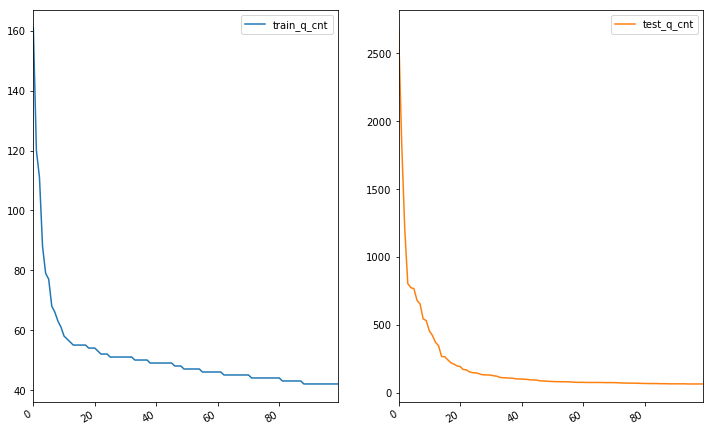

In [15]:
top_n = 100


df = pd.DataFrame({'train_q_cnt': [list(t) for t in zip(*TrainQCounter.most_common(top_n))][1],
                  'test_q_cnt': [list(t) for t in zip(*TestQCounter.most_common(top_n))][1]
                                                                                            })


df[['train_q_cnt', 'test_q_cnt']].plot(subplots=True, layout=(1, 2), figsize=(12, 8), 
                                       sharex=True) #sharey = True


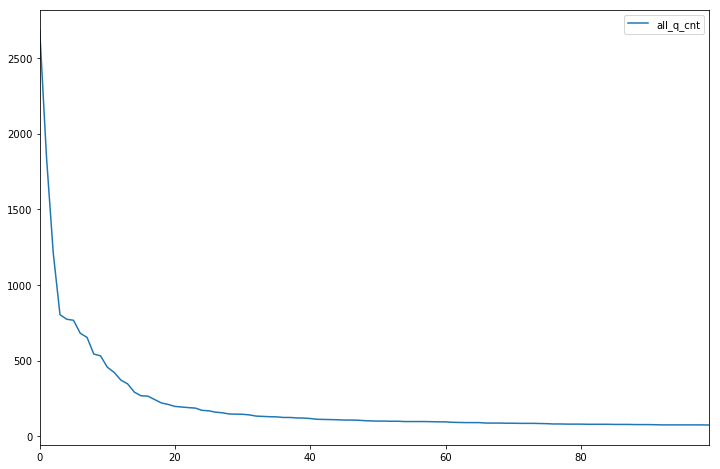

In [16]:
all_q_counter = TrainQCounter + TestQCounter

df = pd.DataFrame({'all_q_cnt': [list(t) for t in zip(*all_q_counter.most_common(top_n))][1] })

df.plot.line(figsize=(12, 8))

In [17]:
print('Traing Q appearance count')
pd.DataFrame(TrainQCounter.most_common(top_n)).head(10)

print('Testing Q appearance count')
pd.DataFrame(TestQCounter.most_common(top_n)).head(10)

print('Training+Testing Q appearance count')
pd.DataFrame(all_q_counter.most_common(top_n)).head(15)

Traing Q appearance count


,0,1
0,What are the best ways to lose weight?,161
1,How can you look at someone's private Instagram account without following them?,120
2,How can I lose weight quickly?,111
3,What's the easiest way to make money online?,88
4,Can you see who views your Instagram?,79
5,What are some things new employees should know going into their first day at AT&T?,77
6,What do you think of the decision by the Indian Government to demonetize 500 and 1000 rupee notes?,68
7,Which is the best digital marketing course?,66
8,How can you increase your height?,63
9,How do l see who viewed my videos on Instagram?,61


Testing Q appearance count


,0,1
0,What,2686
1,How,1848
2,What is,1212
3,What are,803
4,How do,773
5,What is the,766
6,What is?,680
7,Why,653
8,Is,543
9,How do I,531


Training+Testing Q appearance count


,0,1
0,What,2686
1,How,1848
2,What is,1212
3,What are,803
4,How do,773
5,What is the,766
6,What is?,680
7,Why,653
8,Is,543
9,How do I,531


In [18]:
print('Traing Q appearance count')
len(TrainQCounter)
len(TrainQCounter)/sum(TrainQCounter.values())

print('Testing Q appearance count')
len(TestQCounter)/sum(TestQCounter.values())

print('Training+Testing Q appearance count')
len(all_q_counter)/sum(all_q_counter.values())


Traing Q appearance count


537362

0.6645749338346236

Testing Q appearance count


0.930138852653854

Training+Testing Q appearance count


0.8707058615621475

### Observations - Training dataset

In training dataset, the top frequent questions are 

1. weight loss
2. social - Instragram
3. weight loss
4. money - personal
5. social - Instragram
6. job
7. money - public policy
8. education
9. health
10. social - Instagram

If the questions are randomly sampled from Quora, then Weight loss and Instagram(social) seem to the most concerned questions among users.   

### Observations - Testing dataset

In the testing dataset, top questions are meaningless. Most of them are WH-words questions without noun-phase referring to the subjects/objects. In addition, they are very short, containing one or few words only, and several dont have question mark (?). Only #10 has subject - I.

Apprarently, these single WH-word questions are not valid question in Quora. It it likely that these question are added into test dataset to avoid "cheating"(i.e. overfitting). These questions are "noises" added to the dataset to test the generalization capability of the classification model.

From these observations, we could use word count of question and punctuations (e.g. does the question contain question mark ?) as features. 

### Observations - Training+Testing dataset

WH-words occupies top rankings. In addition, "What", "How", and ..etc only appear in the testing dataset. The intuition is that we should examine syntactical validility and grammar rules of the questions. We could use Dependency parsing to analyze  the sentence structure and relationship among words.

# NLP Processing

1. Frequency Counters - we use spacy's NLP process module to extract NLP information, such as tokenm lemma, POS tags, and Depedency information, and count the frequency  
    1.1 Token Counter  
    1.2 Lemma Counter  
    1.3 Depedency Counter  
    1.4 Part Of Speech Counter  
    1.5 Tag Counter  
2. Document Similarity
3. SVO extraction
 

In [19]:
token_cntr = {1: Counter(), 2: Counter()}
lemma_cntr = {1: Counter(), 2: Counter()}
pos_cntr = {1: Counter(), 2: Counter()}
tag_cntr = {1: Counter(), 2: Counter()}
dep_cntr = {1: Counter(), 2: Counter()}
stem_cntr = {1: Counter(), 2: Counter()}

ent_lbl_cntr = {1: Counter(), 2: Counter()}
ent_name_cntr = {1: Counter(), 2: Counter()}

In [20]:
count = 0
t0 = time.time()
def nlp_parse(q1, q2 = None, training = True):
    global count
    global t0
    def nlp_process(q, training ):
        doc = nlp(q)
        token = []
        token = []
        lemma = []
        pos = []
        tag = []
        dep = []
        alpha = []
        stop =[] 
        stem = []
        
        for w in doc:
            token.append(w.text)
            lemma.append(w.lemma_)
            pos.append(w.pos_)
            tag.append(w.tag_)
            dep.append(w.dep_)
            alpha.append(w.is_alpha)
            stop.append(w.is_stop)    
            if w.is_stop is not True and w.pos_ != 'PUNCT' :
                stem.append(w.lemma_)
        
        word_cnt = len(token)
        svo = findSVOs(doc)
#         ents = [ (e.label_, e.text) for e in doc.ents]
        alpha_cnt = sum(alpha)
        stop_cnt = sum(stop)   
        svo_cnt = len(svo)  
        stem_cnt = len(stem)
        
        if training == True:
            dataset = 1
        else:
            dataset = 2
            
        token_cntr[dataset].update(token)
        lemma_cntr[dataset].update(lemma)
        pos_cntr[dataset].update(pos)
        tag_cntr[dataset].update(tag)
        dep_cntr[dataset].update(dep)
        stem_cntr[dataset].update(stem)
        for e in doc.ents:
            ent_lbl_cntr[dataset].update((e.label_,))
            ent_name_cntr[dataset].update((e.text,))
            
#         return doc, token, lemma, pos, tag, dep, svo, ents, word_cnt, alpha_cnt, stop_cnt, svo_cnt
        token_ = " ".join(token)
        lemma_ = " ".join(lemma)
        pos_ = " ".join(pos)
        tag_ = " ".join(tag)
        dep_ = " ".join(dep)
        stem_ = " ".join(stem)

        return doc, token_, lemma_, pos_, tag_, dep_, stem_, word_cnt, alpha_cnt, stop_cnt, svo_cnt, stem_cnt
#         return doc, token_, lemma_, pos_, tag_, dep_, svo, ents, word_cnt, alpha_cnt, stop_cnt, svo_cnt
    
    p1 = nlp_process(q1, training)
    if q2 is not None:
        p2 = nlp_process(q2, training)
        doc_sim  = p1[0].similarity(p2[0]) 
    
    count +=1
    # print every 100k iterations
    if (count % 50000) == 0:
        t1 = time.time()
        print("rows processed {:d} time lapsed {:.2f},  iterations/sec {:0.2f}".format(count, t1-t0, count/(t1-t0)))
    
    if q2 is not None:
        return p1[1:]+p2[1:]+(doc_sim,)
    else:     
        return p1[1:] 

In [21]:
print('NLP parse: ready to process for df_train')
count = 0
t0 = time.time()

# df_train_old = df_train
# df_train = df_train_old[:100].copy()

df_train['token1'], df_train['lemma1'], df_train['pos1'], \
    df_train['tag1'], df_train['dep1'], df_train['stem1'], \
    df_train['word_cnt1'], df_train['alpha_cnt1'], df_train['stop_cnt1'], df_train['svo_cnt1'], df_train['stem_cnt1'], \
    df_train['token2'], df_train['lemma2'], df_train['pos2'], \
    df_train['tag2'], df_train['dep1'], df_train['stem2'], \
    df_train['word_cnt2'], df_train['alpha_cnt2'], df_train['stop_cnt2'], df_train['svo_cnt2'], df_train['stem_cnt2'], \
    df_train['doc_sim'] = zip( *df_train.apply(lambda df: nlp_parse(df['q1'], df['q2'], training = True), axis=1)) 

#     df_train.to_pickle("./data/df_train.pkl")

NLP parse: ready to process for df_train
rows processed 50000 time lapsed 169.32,  iterations/sec 295.30
rows processed 100000 time lapsed 336.46,  iterations/sec 297.21
rows processed 150000 time lapsed 503.82,  iterations/sec 297.72
rows processed 200000 time lapsed 667.61,  iterations/sec 299.58
rows processed 250000 time lapsed 823.66,  iterations/sec 303.52
rows processed 300000 time lapsed 979.14,  iterations/sec 306.39
rows processed 350000 time lapsed 1136.56,  iterations/sec 307.95
rows processed 400000 time lapsed 1292.78,  iterations/sec 309.41


In [22]:
df_train[['question1', 'question2','stem1', 'stem2', 'stem_cnt1','stem_cnt2','is_duplicate']].sample(5)

,question1,question2,stem1,stem2,stem_cnt1,stem_cnt2,is_duplicate
33013,Is Neil deGrasse Tyson an islamophobe?,How is Neil deGrasse Tyson as a physicist?,neil degrasse tyson islamophobe,neil degrasse tyson physicist,4,4,0
180421,What's a good and easy programming language to learn?,What is the best computer programming language to learn first?,good easy programming language learn,good computer programming language learn,5,5,1
373794,"If the devil asked God to forgive him, being that God is all forgiving, would he forgive Lucifer and let him return ...",Will god destroy the devil in the end time or will he forgive him?,devil ask god forgive god forgive forgive lucifer let return kingdom heaven angel,god destroy devil end time forgive,13,6,1
76851,Is there any possibility to back of torrentz.eu?,What is alternate of torrentz.eu?,possibility torrentz.eu,alternate torrentz.eu,2,2,0
46202,How can I spend my monthly salary of 15k wisely if staying in Bangalore at the age of 22?,How can I spend my monthly salary of 20k wisely if staying in Bangalore at the age of 22?,spend monthly salary 15k wisely stay bangalore age 22,spend monthly salary 20k wisely stay bangalore age 22,9,9,0


In [24]:
print('NLP parse: ready to process for df_test')
count = 0
t0 = time.time()


df_test['token1'], df_test['lemma1'], df_test['pos1'], \
    df_test['tag1'], df_test['dep1'], df_test['stem1'], \
    df_test['word_cnt1'], df_test['alpha_cnt1'], df_test['stop_cnt1'], df_test['svo_cnt1'], df_test['stem_cnt1'],\
    df_test['token2'], df_test['lemma2'], df_test['pos2'], \
    df_test['tag2'], df_test['dep1'], df_test['stem2'], \
    df_test['word_cnt2'], df_test['alpha_cnt2'], df_test['stop_cnt2'], df_test['svo_cnt2'], df_test['stem_cnt2'],\
    df_test['doc_sim'] = zip( *df_test.apply(lambda df: nlp_parse(df['q1'], df['q2'], training = False), axis=1))

NLP parse: ready to process for df_test
rows processed 50000 time lapsed 156.39,  iterations/sec 319.71
rows processed 100000 time lapsed 312.05,  iterations/sec 320.46
rows processed 150000 time lapsed 467.20,  iterations/sec 321.06
rows processed 200000 time lapsed 624.41,  iterations/sec 320.30
rows processed 250000 time lapsed 780.75,  iterations/sec 320.20
rows processed 300000 time lapsed 940.05,  iterations/sec 319.13
rows processed 350000 time lapsed 1098.42,  iterations/sec 318.64
rows processed 400000 time lapsed 1255.21,  iterations/sec 318.67
rows processed 450000 time lapsed 1411.56,  iterations/sec 318.80
rows processed 500000 time lapsed 1570.19,  iterations/sec 318.43
rows processed 550000 time lapsed 1729.37,  iterations/sec 318.03
rows processed 600000 time lapsed 1886.71,  iterations/sec 318.01
rows processed 650000 time lapsed 2043.78,  iterations/sec 318.04
rows processed 700000 time lapsed 2199.17,  iterations/sec 318.30
rows processed 750000 time lapsed 2358.50, 

In [26]:
df_test[['question1', 'question2','stem1', 'stem2', 'stem_cnt1','stem_cnt2']].sample(5)

,question1,question2,stem1,stem2,stem_cnt1,stem_cnt2
1720821,How do I should I save up to move to Germany from the US?,How much money should I save up to move to Germany from the visa?,save germany united states,money save germany visa,4,4
1152395,How english you take care of an infected belly button piercing?,What you tell if you have an infected belly button piercing?,english care infected belly button pierce,tell infect belly button pierce,6,5
545700,Which are the best ways to itis weight?,What is the modulus way to lose weigh?,good way itis weight,modulus way lose weigh,4,4
1991234,What is Sensex? mba can I enter in the Sensex market?,What reaction sensex?,sensex mba enter sensex market,reaction sensex,5,2
15983,Why do most Indians good like cricket?,Why are Bengalis crazy about football?,indians good like cricket,bengalis crazy football,4,3


### Unigram and  Counter Analysis
1. Token
2. Lemma
3. Stem
4. Part-Of-Speech tags
5. TAGs (spacy model)
6. Dependency
7. Document Similarity

##### 1. Unigram - Tokens

,cnt,token
0,6042683,?
1,2441721,the
2,2034517,What
3,1562058,is
4,1501121,I
5,1462113,a
6,1418703,How
7,1384004,to
8,1381874,in
9,1069661,of


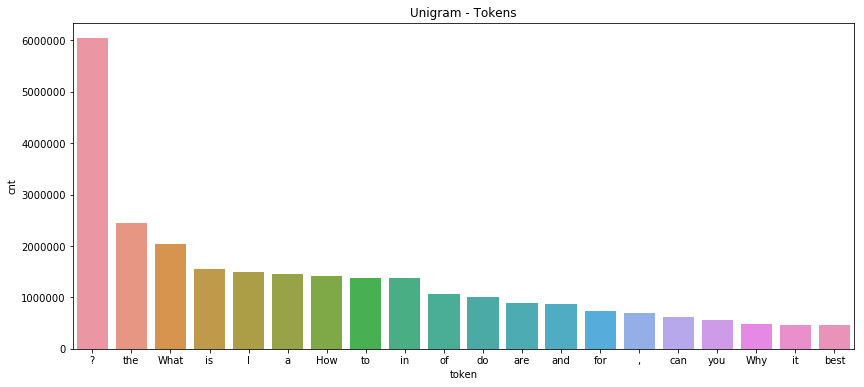

In [27]:
top_n = 20

# for both training and test dataset
all_token_cntr = token_cntr[1] + token_cntr[2]


df_all_tokens = pd.DataFrame({'token': [list(t) for t in zip(*all_token_cntr.most_common(top_n))][0],
                  'cnt': [list(t) for t in zip(*all_token_cntr.most_common(top_n))][1]})


plt.figure(figsize=(14,6))
g = sns.barplot(x="token", y="cnt", data=df_all_tokens)
g.set_title('Unigram - Tokens')

df_all_tokens.head(10)

##### 2. Unigram - Lemmas

,cnt,lemma
0,6042683,?
1,4070218,-PRON-
2,3621964,be
3,2478843,the
4,2260545,what
5,1672724,do
6,1528749,how
7,1478499,a
8,1422505,in
9,1389112,to


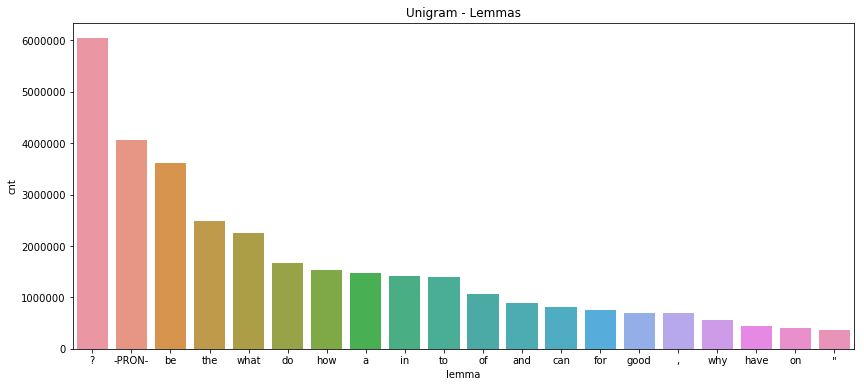

In [28]:

#######
all_lemma_cntr = lemma_cntr[1] + lemma_cntr[2]


df_all_lemma = pd.DataFrame({'lemma': [list(t) for t in zip(*all_lemma_cntr.most_common(top_n))][0],
                  'cnt': [list(t) for t in zip(*all_lemma_cntr.most_common(top_n))][1]})


plt.figure(figsize=(14,6))
g = sns.barplot(x="lemma", y="cnt", data=df_all_lemma)
g.set_title('Unigram - Lemmas')

df_all_lemma.head(10)

##### 3. Unigram - Stem Words

,cnt,stem
0,700639,good
1,206849,india
2,193279,like
3,174004,people
4,173777,way
5,162698,'s
6,124733,time
7,121998,learn
8,118931,difference
9,114821,quora


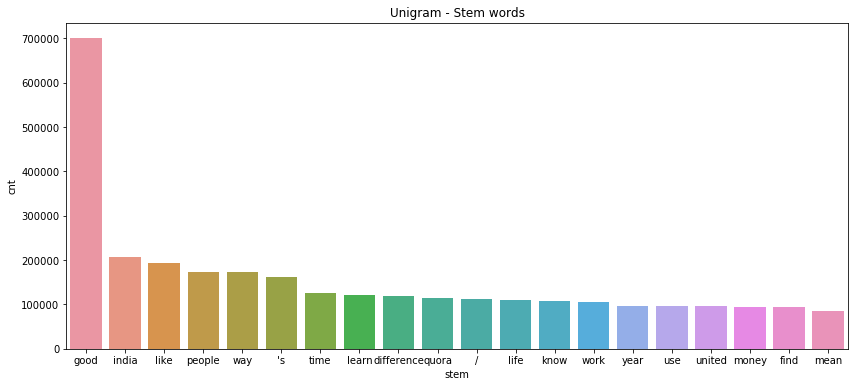

In [29]:
#######
all_stem_cntr = stem_cntr[1] + stem_cntr[2]


df_all_stem = pd.DataFrame({'stem': [list(t) for t in zip(*all_stem_cntr.most_common(top_n))][0],
                  'cnt': [list(t) for t in zip(*all_stem_cntr.most_common(top_n))][1]})


plt.figure(figsize=(14,6))
g = sns.barplot(x="stem", y="cnt", data=df_all_stem)
g.set_title('Unigram - Stem words')

df_all_stem.head(15)

##### 4. Counters - POS tags

,cnt,pos
0,16323457,NOUN
1,13680503,VERB
2,8130709,PUNCT
3,6596362,ADP
4,6139441,ADJ
5,5005235,PROPN
6,4950870,DET
7,4328873,ADV
8,3272730,PRON
9,1354816,CCONJ


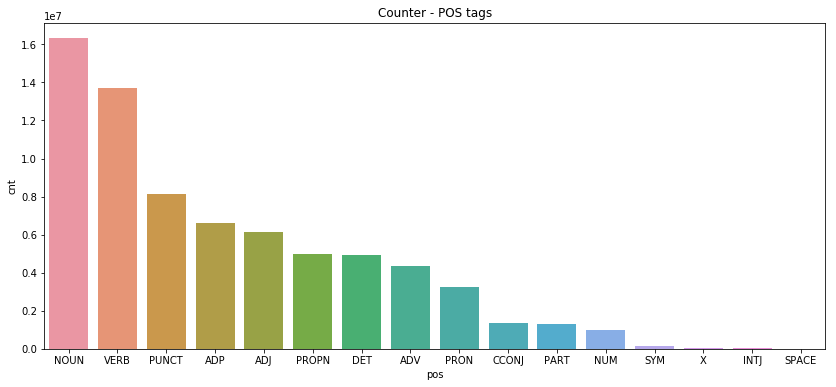

In [30]:
#######
all_pos_cntr = pos_cntr[1] + pos_cntr[2]


df_all_pos = pd.DataFrame({'pos': [list(t) for t in zip(*all_pos_cntr.most_common(top_n))][0],
                  'cnt': [list(t) for t in zip(*all_pos_cntr.most_common(top_n))][1]})


plt.figure(figsize=(14,6))
g = sns.barplot(x="pos", y="cnt", data=df_all_pos)
g.set_title('Counter - POS tags')

df_all_pos.head(15)

##### 5. Counters - TAGs

,cnt,tag
0,10543514,NN
1,6596362,IN
2,6416167,.
3,4950870,DT
4,4877681,NNP
5,3902354,JJ
6,3810640,VB
7,3374775,NNS
8,3272730,PRP
9,3040644,VBP


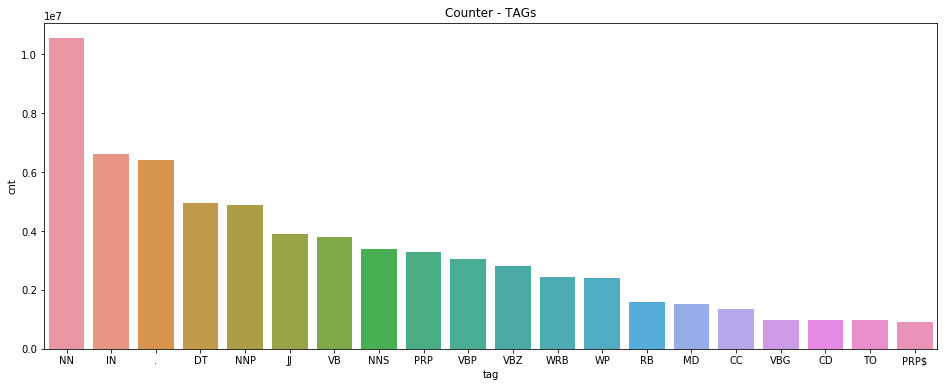

In [31]:
all_tag_cntr = tag_cntr[1] + tag_cntr[2]


df_all_tag = pd.DataFrame({'tag': [list(t) for t in zip(*all_tag_cntr.most_common(top_n))][0],
                  'cnt': [list(t) for t in zip(*all_tag_cntr.most_common(top_n))][1]})


plt.figure(figsize=(16,6))
g = sns.barplot(x="tag", y="cnt", data=df_all_tag)
g.set_title('Counter - TAGs')

df_all_tag.head(15)

##### 6. Dependency

,cnt,tag
0,8224604,punct
1,6720333,nsubj
2,6555270,ROOT
3,5852295,prep
4,5373030,pobj
5,5075726,det
6,4232525,aux
7,4097564,compound
8,3879458,dobj
9,3762505,advmod


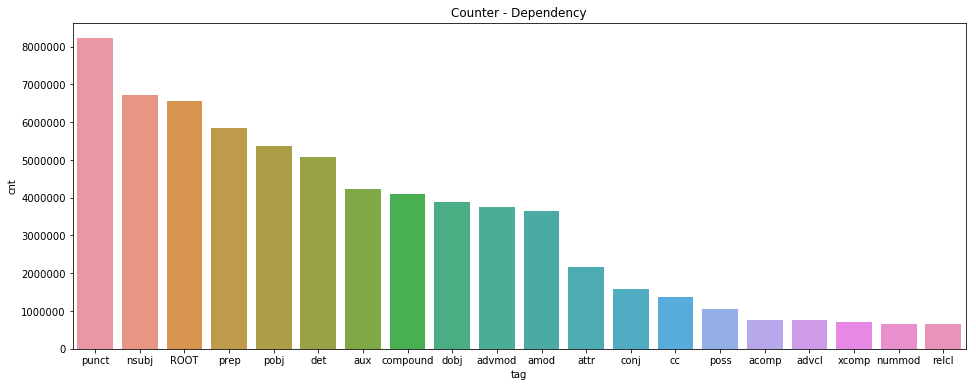

In [32]:
all_dep_cntr = dep_cntr[1] + dep_cntr[2]


df_all_dep = pd.DataFrame({'tag': [list(t) for t in zip(*all_dep_cntr.most_common(top_n))][0],
                  'cnt': [list(t) for t in zip(*all_dep_cntr.most_common(top_n))][1]})


plt.figure(figsize=(16,6))
g = sns.barplot(x="tag", y="cnt", data=df_all_dep)
g.set_title('Counter - Dependency')

df_all_dep.head(15)

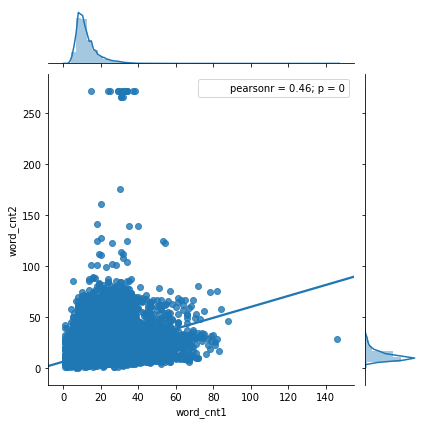

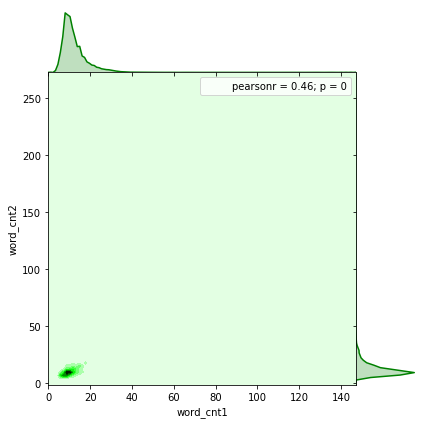

In [33]:
g = sns.jointplot("word_cnt1", "word_cnt2", df_train, kind='reg')
plt.show()

g = sns.jointplot("word_cnt1", "word_cnt2", df_train, kind="kde", space=0, color="g")
# g.fig.get_axes()[0].set_yscale('log')
# g.fig.get_axes()[0].set_xscale('log')
plt.show()

### Question pairs without any stem words

In [34]:
x = df_train.query("stem1 == '' and stem2 == ''")
x.transpose()

,9581,18455,25789,29040,35641,36025,42947,44629,45883,55139,...,337996,338333,339101,339961,341976,348903,356897,365794,368788,383790
id,9581,18455,25789,29040,35641,36025,42947,44629,45883,55139,...,337996,338333,339101,339961,341976,348903,356897,365794,368788,383790
qid1,18608,34964,48049,53770,65095,65737,77321,80072,53770,97238,...,177403,233693,444993,467653,469891,477519,225271,82154,149300,515751
qid2,18609,34965,48050,53771,65096,65738,77322,80073,82154,97239,...,465516,149300,34965,467654,469892,477520,34965,419957,315212,391150
question1,How can I just be myself?,What you have never done?,When you are not alone?,What is what and why is that what?,What to do ?,"What would be there, if there was nothing?",How could I do this to her?,Am I really alone?,What is what and why is that what?,Can you name something you have too much of?,...,Who would you be if you were not you?,What should I do when I have nothing to do?,What is something you never do?,How much is enough?,Do we do what we do?,What is a now?,What is something that you will never do?,What is it that you are doing and why?,What do you do when you've nothing to do?,How do I get over someone that was never mine?
question2,How can I not be myself?,What is something you have never done?,What do you do when you are alone?,What is up and why?,What to do?,What was there when nothing was there?,How do I do this?,Am I alone?,What is it that you are doing and why?,Can you name something you can't get enough of?,...,What would you be doing if you were not doing what you are doing now?,What do you do when you've nothing to do?,What is something you have never done?,When is enough enough?,Why do we do what we do?,What is now?,What is something you have never done?,What are you doing?,What should you do when you have nothing?,How do I get over someone I will never have?
is_duplicate,0,1,0,0,0,0,0,1,0,0,...,0,1,1,0,0,1,0,0,0,0
q1,How can I just be myself?,What you have never done?,When you are not alone?,What is what and why is that what?,What to do ?,"What would be there, if there was nothing?",How could I do this to her?,Am I really alone?,What is what and why is that what?,Can you name something you have too much of?,...,Who would you be if you were not you?,What should I do when I have nothing to do?,What is something you never do?,How much is enough?,Do we do what we do?,What is a now?,What is something that you will never do?,What is it that you are doing and why?,What do you do when you have nothing to do?,How do I get over someone that was never mine?
q2,How can I not be myself?,What is something you have never done?,What do you do when you are alone?,What is up and why?,What to do?,What was there when nothing was there?,How do I do this?,Am I alone?,What is it that you are doing and why?,Can you name something you cannot get enough of?,...,What would you be doing if you were not doing what you are doing now?,What do you do when you have nothing to do?,What is something you have never done?,When is enough enough?,Why do we do what we do?,What is now?,What is something you have never done?,What are you doing?,What should you do when you have nothing?,How do I get over someone I will never have?
q1_len,25,25,23,34,12,42,27,18,34,44,...,37,43,31,19,20,14,41,38,43,46
q2_len,24,38,34,19,11,38,17,11,38,48,...,69,43,38,22,24,12,38,19,41,44


# Common Share Analysis
#### tokens, lemmas, and stem words

In [35]:
def word_share(token1, token2):
    set1 = set(token1.split())
    set2 = set(token2.split())
    
    union_size = len(set1 | set2)
    if union_size == 0:
        return 0
    
    word_share = len(set1 & set2)/union_size
    return word_share

df_train['token_share'] = df_train.apply(lambda df: word_share(df['token1'], df['token2']), axis = 1) 
df_test['token_share'] = df_test.apply(lambda df: word_share(df['token1'], df['token2']), axis = 1) 

df_train['lemma_share'] = df_train.apply(lambda df: word_share(df['lemma1'], df['lemma2']), axis = 1) 
df_test['lemma_share'] = df_test.apply(lambda df: word_share(df['lemma1'], df['lemma2']), axis = 1) 

df_train['stem_share'] = df_train.apply(lambda df: word_share(df['stem1'], df['stem2']), axis = 1) 
df_test['stem_share'] = df_test.apply(lambda df: word_share(df['stem1'], df['stem2']), axis = 1) 

In [36]:
df_train.sample(n=5)
df_train.describe(include='all').transpose()

,id,qid1,qid2,question1,question2,is_duplicate,q1,q2,q1_len,q2_len,...,stem2,word_cnt2,alpha_cnt2,stop_cnt2,svo_cnt2,stem_cnt2,doc_sim,token_share,lemma_share,stem_share
51278,51278,90977,8003,What are your thoughts about reservations in private sectors?,What are your thoughts about proposals for reservation in the private sector?,1,What are your thoughts about reservations in private sectors?,What are your thoughts about proposals for reservation in the private sector?,61,77,...,thought proposal reservation private sector,13,12,7,0,5,0.972462,0.533333,0.769231,0.800000
231933,231933,341844,341845,What are the strongest majors in terms of job prospects and what are the weakest majors at the University of Mary Wa...,What are the strongest majors in terms of job prospects and what are the weakest majors at the University of Washing...,0,What are the strongest majors in terms of job prospects and what are the weakest majors at the University of Mary Wa...,What are the strongest majors in terms of job prospects and what are the weakest majors at the University of Washing...,125,120,...,strong major term job prospect weak major university washington,22,21,12,0,9,0.996510,0.944444,0.941176,0.888889
80350,80350,136615,136616,Should I avoid using default methods in Java interfaces?,Compare the American friendship with the Chinese friendship?,0,Should I avoid using default methods in Java interfaces?,Compare the American friendship with the Chinese friendship?,56,60,...,compare american friendship chinese friendship,9,8,3,0,5,0.629587,0.062500,0.062500,0.000000
189811,189811,288691,288692,What is the deal with Trump's hair?,What's up with Donald Trump's hair?,1,What is the deal with Trump's hair?,what is up with Donald Trump's hair?,35,36,...,donald trump 's hair,9,7,4,0,4,0.955044,0.500000,0.636364,0.600000
191332,191332,112121,176006,Can a bad person become good?,What factors cause a bad person become good?,1,Can a bad person become good?,What factors cause a bad person become good?,29,44,...,factor cause bad person good,9,8,3,0,5,0.965531,0.600000,0.600000,0.600000


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
id,404290,NaN,NaN,NaN,202144,116709,0,101072,202144,303217,404289
qid1,404290,NaN,NaN,NaN,217244,157752,1,74437.5,192182,346574,537932
qid2,404290,NaN,NaN,NaN,220956,159903,2,74727,197052,354692,537933
question1,404290,290457,How do I improve my English speaking?,50,NaN,NaN,NaN,NaN,NaN,NaN,NaN
question2,404290,299175,How can you look at someone's private Instagram account without following them?,120,NaN,NaN,NaN,NaN,NaN,NaN,NaN
is_duplicate,404290,NaN,NaN,NaN,0.369198,0.482588,0,0,0,1,1
q1,404290,290436,How do I improve my English speaking?,50,NaN,NaN,NaN,NaN,NaN,NaN,NaN
q2,404290,299149,How can you look at someone's private Instagram account without following them?,120,NaN,NaN,NaN,NaN,NaN,NaN,NaN
q1_len,404290,NaN,NaN,NaN,59.7226,30.1083,1,39,52,72,624
q2_len,404290,NaN,NaN,NaN,60.3188,34.0763,0,39,51,72,1170


### Correlation plot

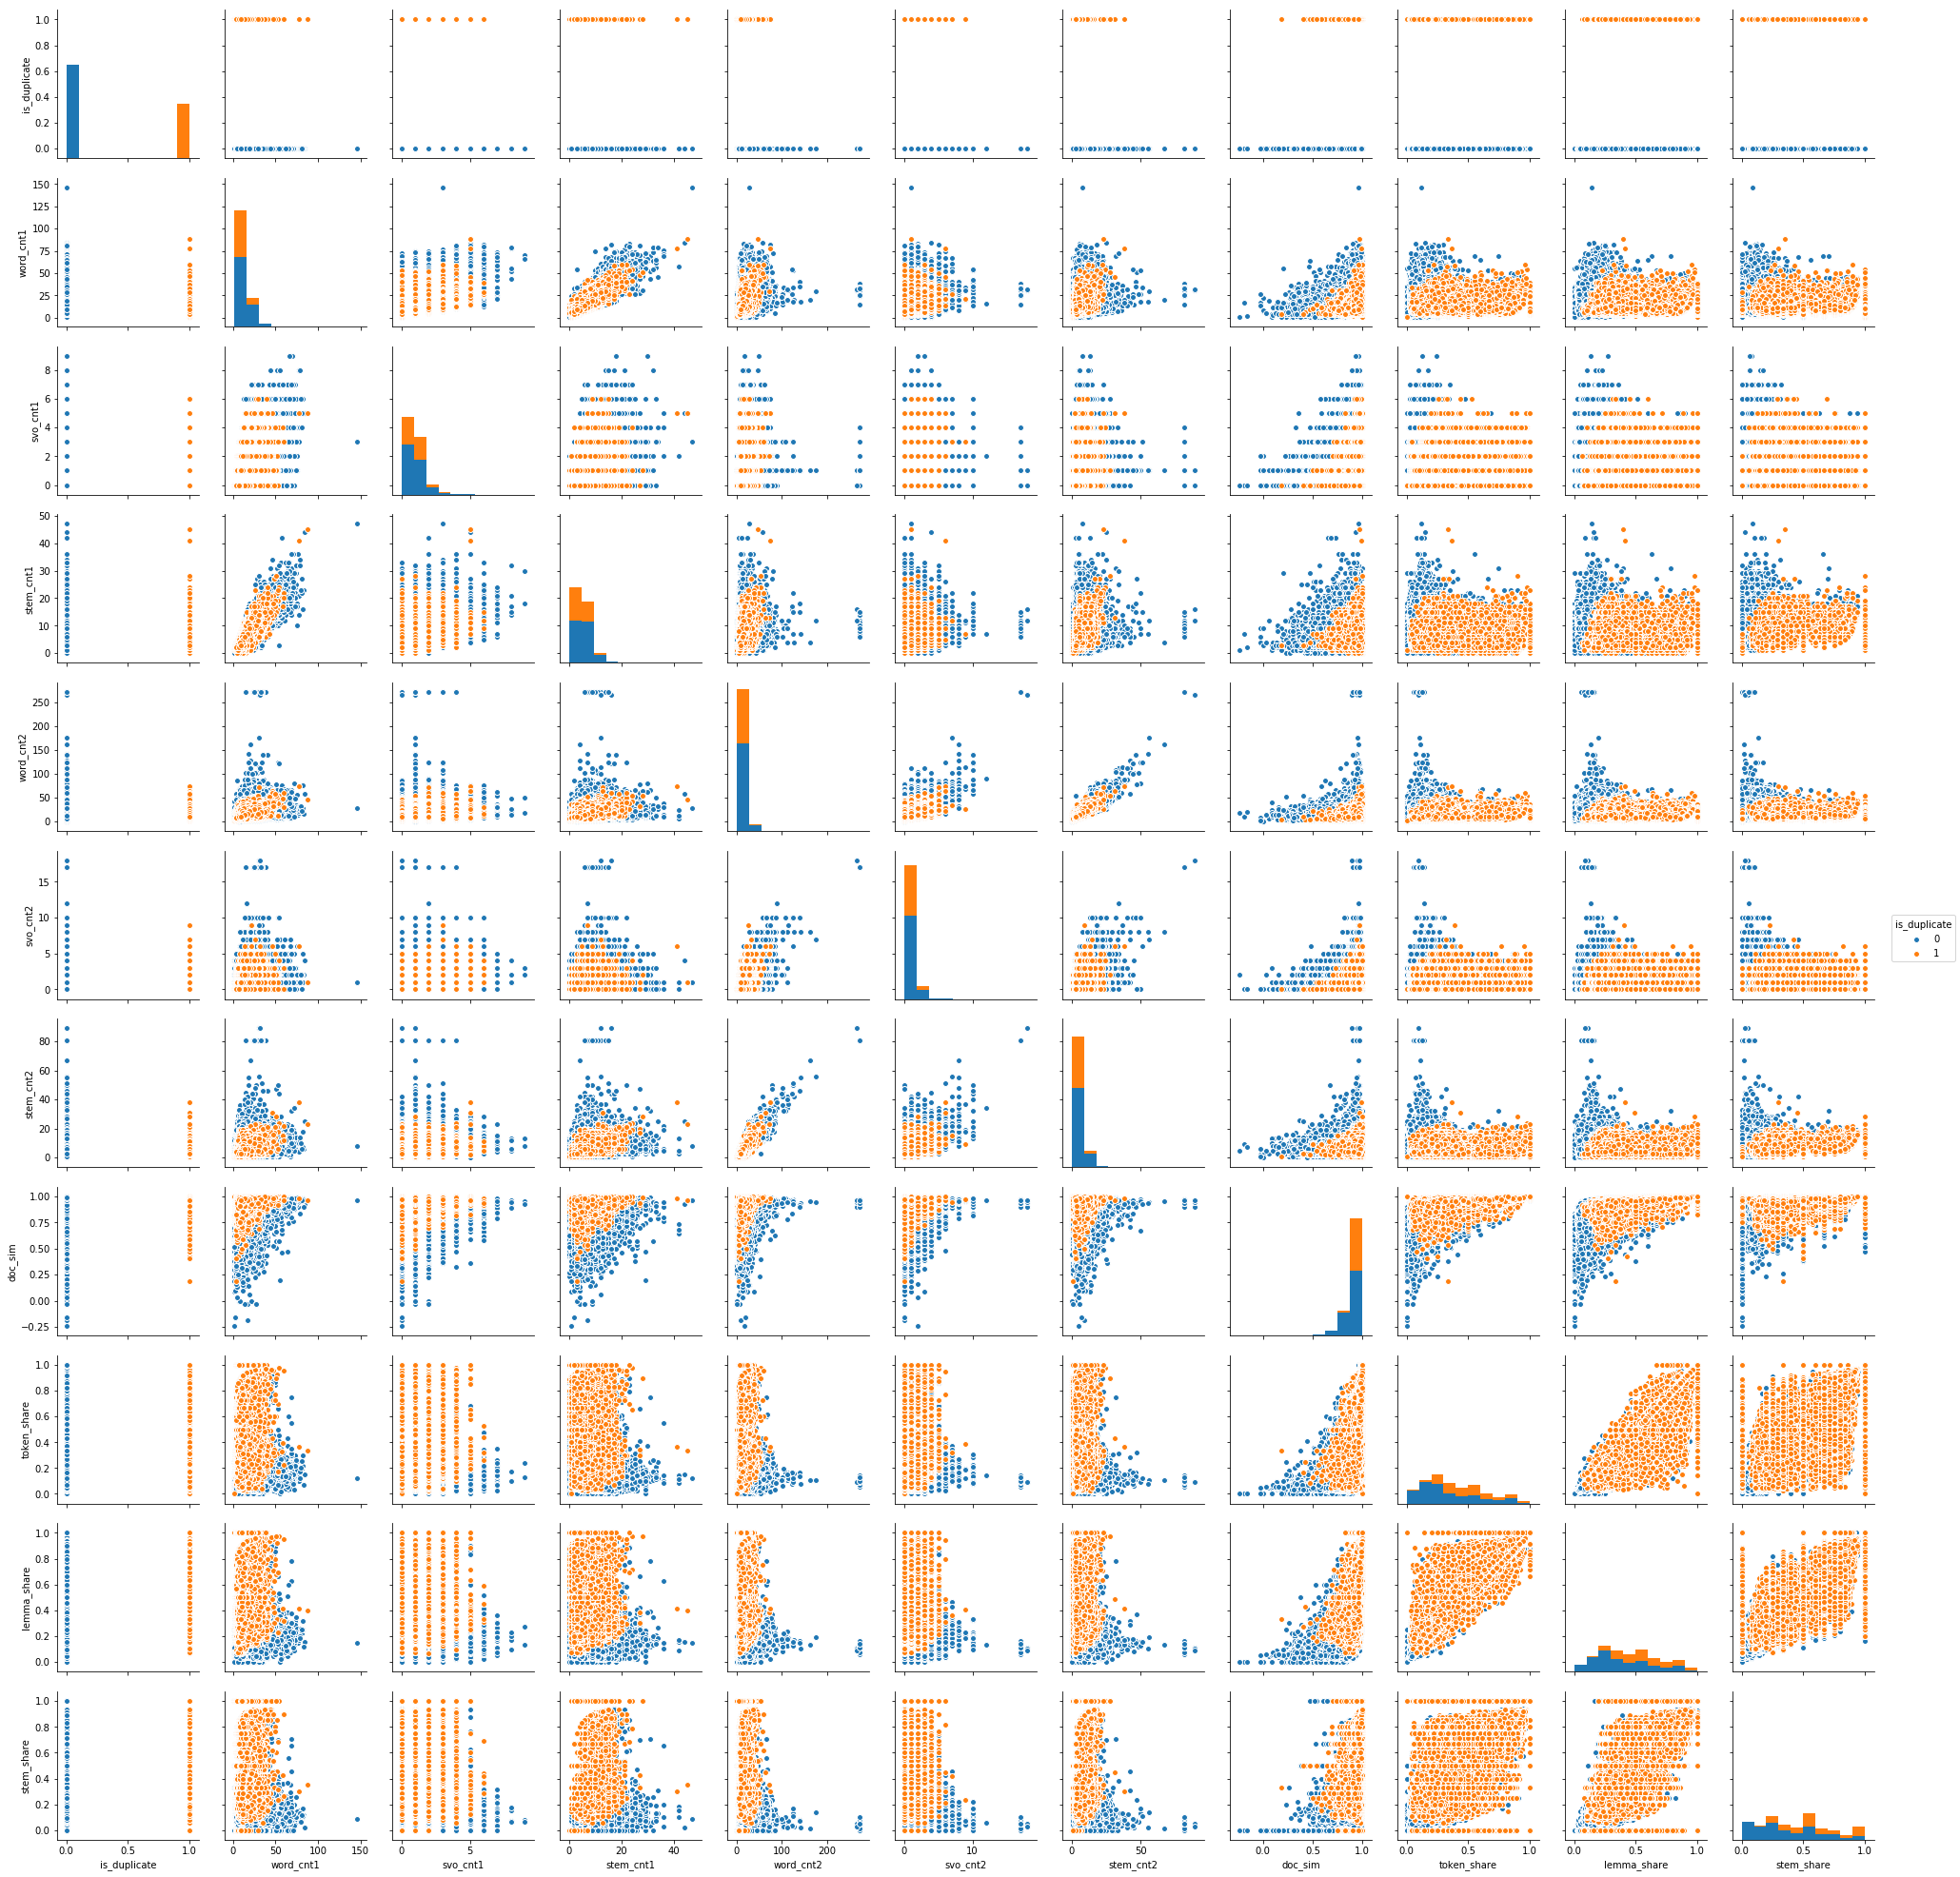

In [37]:
cols = [ 'is_duplicate', 
         'word_cnt1', 'svo_cnt1', 'stem_cnt1', 
        'word_cnt2', 'svo_cnt2', 'stem_cnt2', 
        'doc_sim','token_share', 'lemma_share', 'stem_share']

sns.pairplot(df_train[cols], hue="is_duplicate")

### Probability Distribution 

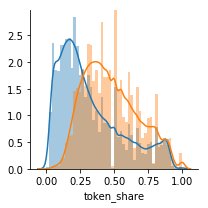

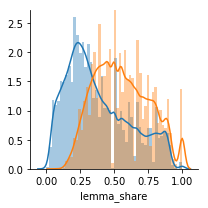

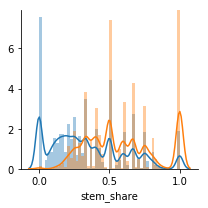

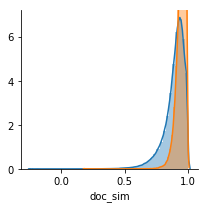

In [40]:
g = sns.FacetGrid(df_train, hue="is_duplicate")
g = g.map(sns.distplot, "token_share")


g = sns.FacetGrid(df_train, hue="is_duplicate")
g = g.map(sns.distplot, "lemma_share")

g = sns.FacetGrid(df_train, hue="is_duplicate")
g = g.map(sns.distplot, "stem_share")

g = sns.FacetGrid(df_train, hue="is_duplicate")
g = g.map(sns.distplot, "doc_sim")

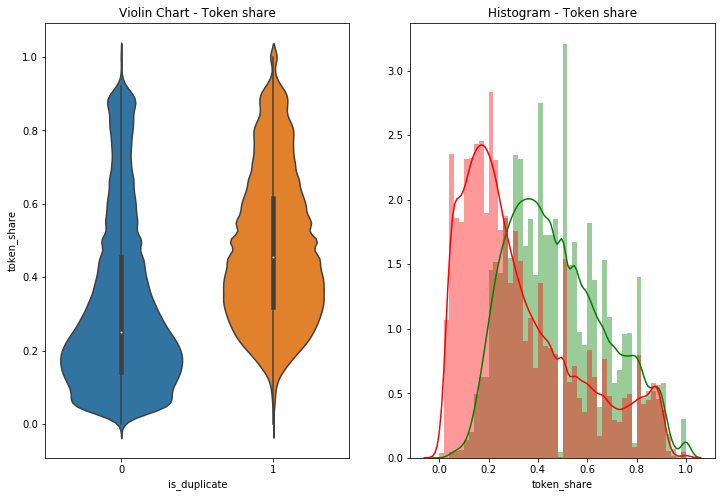

In [41]:
plt.figure(figsize=(12, 8))
plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'token_share', data = df_train)
plt.title('Violin Chart - Token share')

plt.subplot(1,2,2)
sns.distplot(df_train[df_train['is_duplicate'] == 1.0]['token_share'], color = 'green')
sns.distplot(df_train[df_train['is_duplicate'] == 0.0]['token_share'], color = 'red')
plt.title('Histogram - Token share')

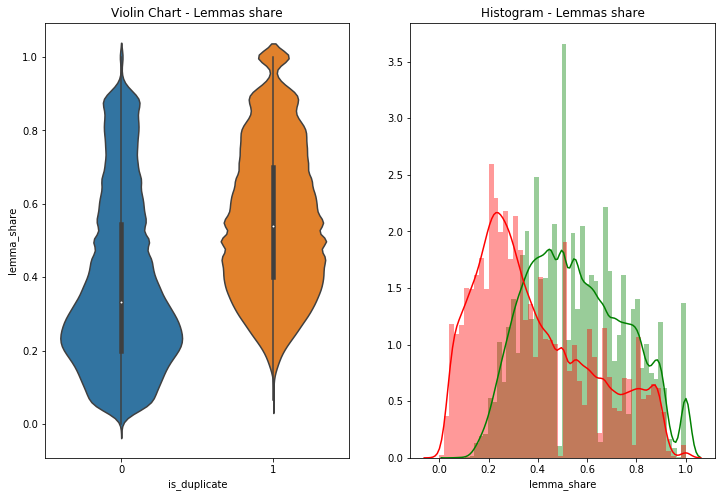

In [42]:
plt.figure(figsize=(12, 8))
plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'lemma_share', data = df_train)
plt.title('Violin Chart - Lemmas share')

plt.subplot(1,2,2)
sns.distplot(df_train[df_train['is_duplicate'] == 1.0]['lemma_share'], color = 'green')
sns.distplot(df_train[df_train['is_duplicate'] == 0.0]['lemma_share'], color = 'red')
plt.title('Histogram - Lemmas share')

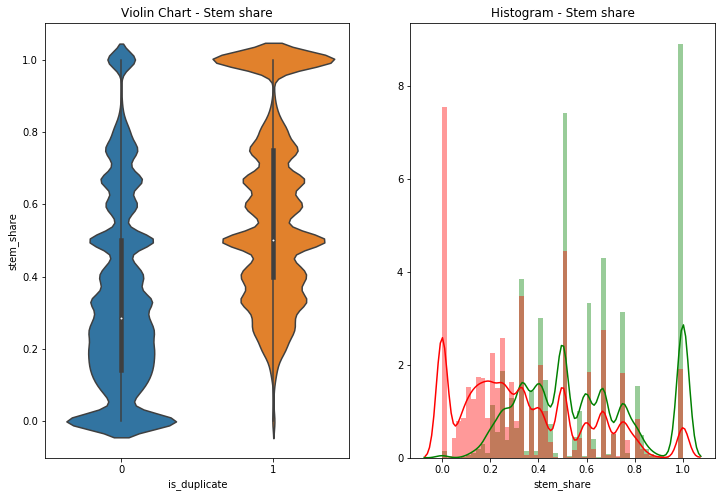

In [43]:
plt.figure(figsize=(12, 8))
plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'stem_share', data = df_train)
plt.title('Violin Chart - Stem share')

plt.subplot(1,2,2)
sns.distplot(df_train[df_train['is_duplicate'] == 1.0]['stem_share'], color = 'green')
sns.distplot(df_train[df_train['is_duplicate'] == 0.0]['stem_share'], color = 'red')
plt.title('Histogram - Stem share')

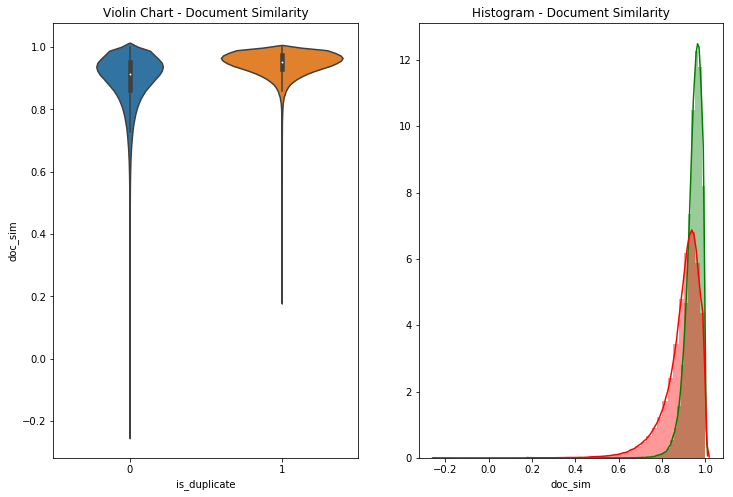

In [44]:
plt.figure(figsize=(12, 8))
plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'doc_sim', data = df_train)
plt.title('Violin Chart - Document Similarity')

plt.subplot(1,2,2)
sns.distplot(df_train[df_train['is_duplicate'] == 1.0]['doc_sim'], color = 'green')
sns.distplot(df_train[df_train['is_duplicate'] == 0.0]['doc_sim'], color = 'red')
plt.title('Histogram - Document Similarity')

----------------

----------------